Four Classes Rotating Separated. Bidimensional.
100 batches of 1371 instances



METHOD: Static lp as classifier
Execution time:  2.7557551100637485
Average error: 78.827
Average macro-F1: 0.208876521453753
Average micro-F1: 0.20979999999999996
Acurácia Média:  21.173
Desvio Padrão:  36.50258140186801
Variância:  1332.438449


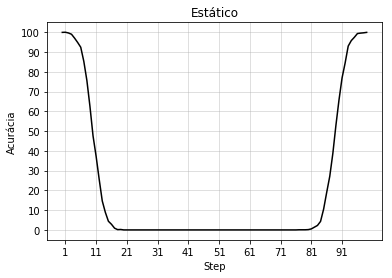

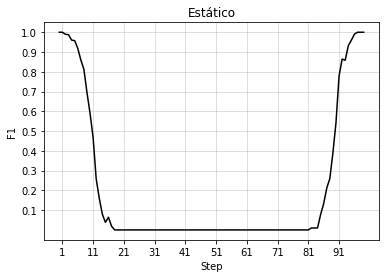




METHOD: Sliding lp as classifier
Execution time:  1.5716034066158615
Average error: 0.024900000000002365
Average macro-F1: 0.9998085674947944
Average micro-F1: 0.9998
Acurácia Média:  99.9751
Desvio Padrão:  0.04003735755516459
Variância:  0.001602990000000095


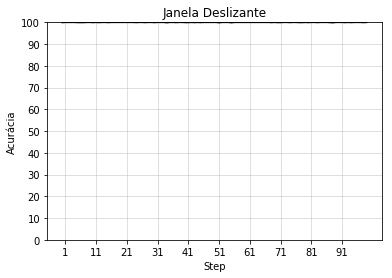

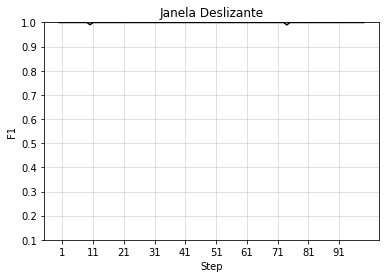




METHOD: Incremental lp as classifier
Execution time:  64.72700140858956
Average error: 78.884
Average macro-F1: 0.20941010539101762
Average micro-F1: 0.21110000000000004
Acurácia Média:  21.116
Desvio Padrão:  36.08940406823033
Variância:  1302.445086


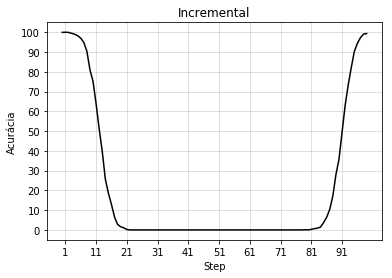

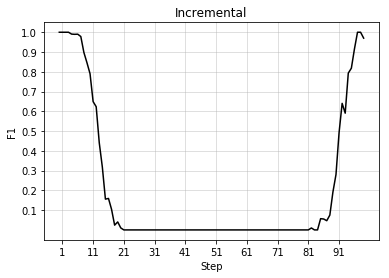




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  11.582144968716506
Average error: 0.017799999999994043
Average macro-F1: 0.9998057848880745
Average micro-F1: 0.9998
Acurácia Média:  99.9822
Desvio Padrão:  0.03590487432090633
Variância:  0.001289160000000079


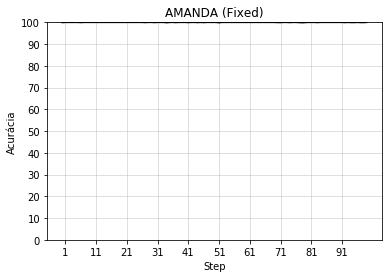

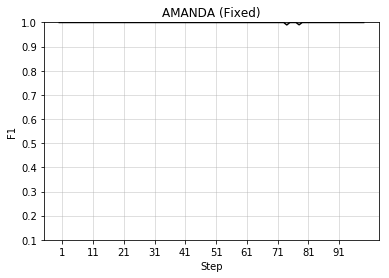




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.31 | Std keeping percentage=0.19
Execution time:  12.997219520706324
Average error: 0.01629999999998688
Average macro-F1: 0.9998999599839936
Average micro-F1: 0.9999000000000001
Acurácia Média:  99.98370000000001
Desvio Padrão:  0.0333962572753311
Variância:  0.0011153100000001052


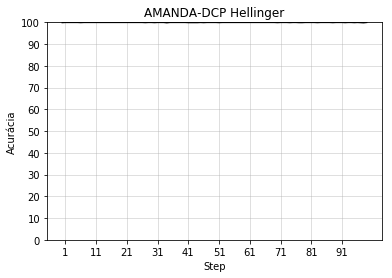

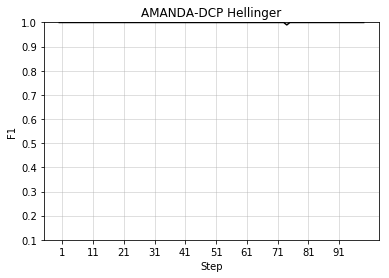




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.22 | Std keeping percentage=0.11
Execution time:  12.8080666867168
Average error: 0.015499999999988745
Average macro-F1: 0.9998999599839936
Average micro-F1: 0.9999000000000001
Acurácia Média:  99.98450000000001
Desvio Padrão:  0.031060424980996933
Variância:  0.0009647500000001383


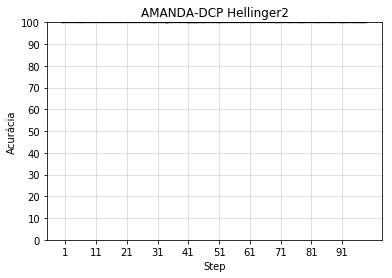

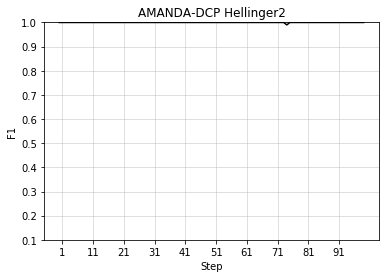




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.14 | Std keeping percentage=0.04
Execution time:  11.99485113705741
Average error: 0.014899999999997249
Average macro-F1: 0.9998057848880745
Average micro-F1: 0.9998
Acurácia Média:  99.9851
Desvio Padrão:  0.032572841448054425
Variância:  0.0010609900000000923


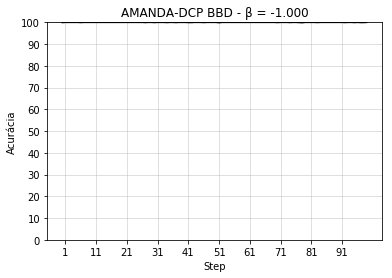

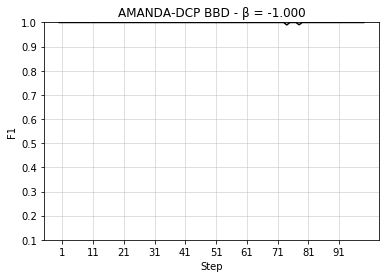

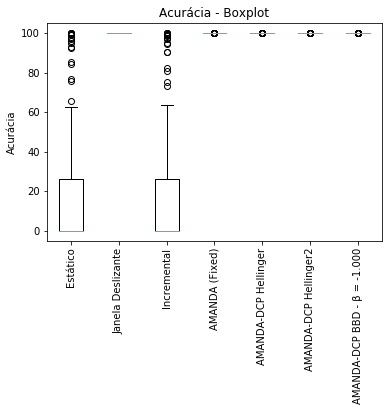

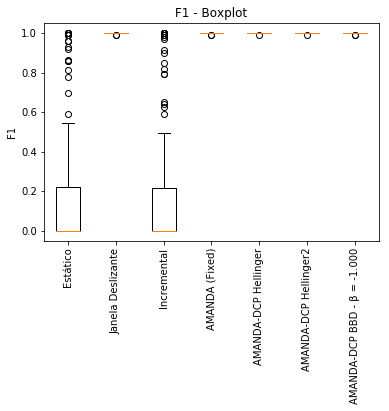

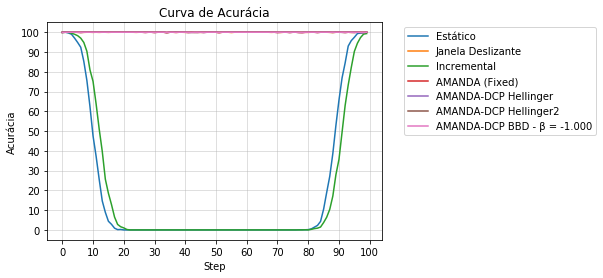

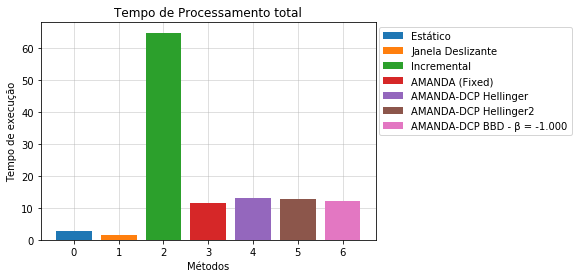

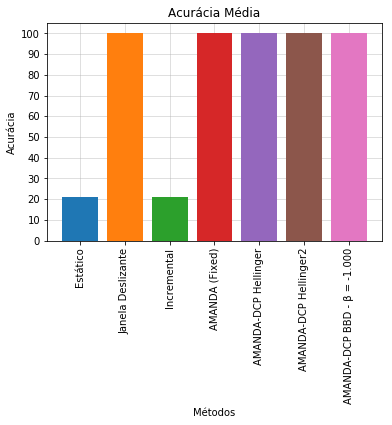

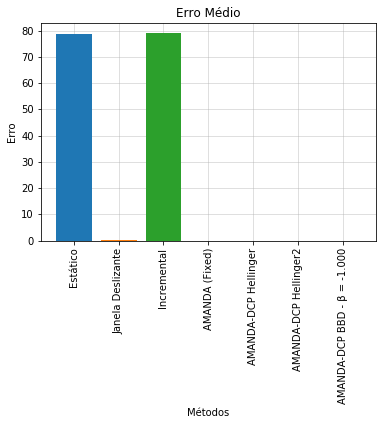

Pos 5 - Redução do Erro (Janela Deslizante):372.1820242762008
Pos 7 - Redução do Erro (Incremental):-0.2692107873234715
Pos 4 - Redução do Erro (AMANDA (Fixed)):372.21555754970956
Pos 3 - Redução do Erro (AMANDA-DCP Hellinger):372.2226420441129
Pos 2 - Redução do Erro (AMANDA-DCP Hellinger2):372.22642044112797
Pos 1 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):372.2292542388892


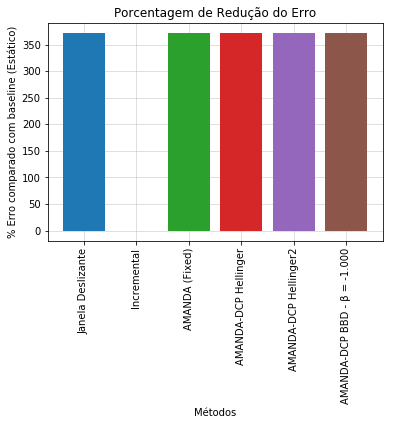

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])

import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 100
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = False
    isImbalanced = False
    externalResults = []
    
    # Load dataset
    dataValues, dataLabels, description = setup.load4CR(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))

    # Static SSL
    experiments[0] = Experiment(static_classifier, 11, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 2, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 2, clfName=sslClassifier)
    
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 2, 0.9, "kde", sslClassifier)

    # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 9, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 10, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    betas = [-1]
    bestK = [2]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
    # Proposed method 4 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 10, None, "kde", sslClassifier, 'HDDDM')

    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 11)
    
    # levelIw matlab results
    #predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, '4CR', steps)
    #externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    

if __name__ == "__main__":
    main()